## following the isoclassify readme and DIRECT tutorial

In [76]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

import os 
import h5py
import numpy as np
import astropy.units as units

os.environ['DUST_DIR'] = '/mnt_home/azuckerman/BL_APF_DAP/mwdust/dust_dir'
from isoclassify import DATADIR
from isoclassify.direct import classify as classify_direct
from isoclassify.extinction import query_dustmodel_coords

# to get properties (not done in tutorial)
from astroquery.gaia import Gaia
from astroquery.simbad import Simbad
import pyvo
 

In [14]:
# get the gaia name
HIP_name = 'HIP10279'
result_table = Simbad.query_objectids(HIP_name)
names = result_table.to_pandas()['ID'].to_list()
gaia_name = [name.decode('utf-8').split(' ')[-1] for name in names if name.decode('utf-8').startswith('Gaia DR2')]
two_MASS_name = [name.decode('utf-8').split('J')[-1] for name in names if name.decode('utf-8').startswith('2MASS')]
(gaia_source_id,) = gaia_name
(id_2MASS,) = two_MASS_name

NameError: name 'Simbad' is not defined

In [28]:
# get the parallax from gaia
query1 = "SELECT source_id, ra, dec, parallax, parallax_error, teff_val, radius_val  FROM gaiadr2.gaia_source WHERE source_id = " + str(gaia_source_id)
job = Gaia.launch_job(query1)
results = job.get_results()
parallax = float(results['parallax']) #[mas --> milliarsec]
u_parallax = float(results['parallax_error']) #[mas]
ra = float(results['ra']) #[deg]
dec = float(results['dec'])  #[deg]
   

In [ ]:
'''
# sample query
import pyvo
service = pyvo.dal.TAPService('https://irsa.ipac.caltech.edu/TAP')
query = """ SELECT ra,dec,j_m,j_msigcom,h_m,h_msigcom,k_m,k_msigcom,ph_qual,cc_flg
           FROM fp_psc
           WHERE designation = '18365633+3847012'
        """
result = service.run_async(query)
tab = result.to_table()
tab
'''

In [29]:
# get the 2MASS photometry
query2 = "SELECT designation,ra,dec,k_m,h_m,j_m,k_cmsig,h_cmsig,j_cmsig FROM fp_psc WHERE designation = '" + str(id_2MASS) + "'"
service = pyvo.dal.TAPService('https://irsa.ipac.caltech.edu/TAP')
results = service.run_async(query2)

k_mag = float(results['k_m']) # [Mag]
h_mag = float(results['h_m']) # [Mag] 
j_mag = float(results['j_m']) # [Mag]
u_k_mag = float(results['k_msigcom']) # [Mag]
u_h_mag = float(results['h_msigcom']) # [Mag] 
u_j_mag = float(results['j_msigcom']) # [Mag]

In [32]:
DATADIR = './BL_APF_DAP/isoclassify/isoclassify/data'

# load the bolometric corrections (BC) model
fn = os.path.join(DATADIR,'bcgrid.h5')
bcmodel = h5py.File(fn,'r', driver='core', backing_store=False)

# initialise the observational data and give it some arbitrary coordinates
x = classify_direct.obsdata()
x.addcoords(ra, dec)

# specify the reddening (dust) map to use
dustmap = 'green19'
dustmodel, ext = query_dustmodel_coords(x.ra, x.dec, dustmap)

In [34]:
# add observational data

# SPECTROSCOPY 
# [Teff, logg, FeH] and [sigma_Teff, sigma_logg, sigma_FeH] 
#x.addspec([5777.,4.44,0.0],[60.,0.07,0.04]) --> from tutorial 

# what I will need -- will read these in from SM
sm_R = 1.659
sm_Teff = 5533.
sm_feh = 0.057
sm_u_R = 0.340
sm_u_Teff = 125.8
sm_u_feh = 0.09
sm_logg = 4.0
sm_u_logg = 0.09
# intial approximation: Mass in Mo = radius in Ro
#sm_M = sm_R
#sm_u_M = sm_u_R
# caluclate surface gravity using this assumption
#G = 6.674*10**(-11) # m^3 kg^-1 s^-2
#unit_convert_factor = (1.989 * 10**30) / (6.957 * 10**8)**2 # [Mo in kg] / [Ro in m]^2
#g = (G*sm_M/sm_R*2) * unit_convert_factor
#logg = np.log(g) # CHECK: Should logg be natural log or log 10? 
x.addspec([sm_Teff, sm_logg , sm_feh], [sm_u_Teff, sm_u_logg , sm_u_feh])


# PARALLAX
x.addplx(parallax/1000,u_parallax/1000) # /1000 to convert to arsec

# 2MASS PHOTOMETRY
x.addjhk([j_mag,h_mag,k_mag],[u_j_mag,u_h_mag,u_k_mag])

# MAGNITUDE
# To use for the distance modulus
x.addmag([j_mag],[u_j_mag]) # IS THIS THE J-MAG? --> yes I think so, since band='jmag' in below call to classify_direct

using max distance: 10.6
using min distance: 10.4
   
teff(K): 5533.0 +/- 125.8
dis(pc): 10.50839508395084 + 0.00451804518045229 - 0.00452804528045192
av(mag): 0.0 + 0.0 - 0.0
rad(rsun): 0.25566601502311054 + 0.012434039953716836 - 0.011696000021844927
lum(lsun): 0.05501420231186008 + 0.0015242147793768854 - 0.0014732130133255916
mabs( jmag ): 6.722335926015383 + 0.029471071628599965 - 0.029672062872263538
fbol(cgs): 1.5939094381930317e-08 + 4.4146814522781964e-10 - 4.2645162172874595e-10
mass(msun): 0.0 + 0.0 - 0.0
density(rhosun): 0.0 + 0.0 - 0.0
-----


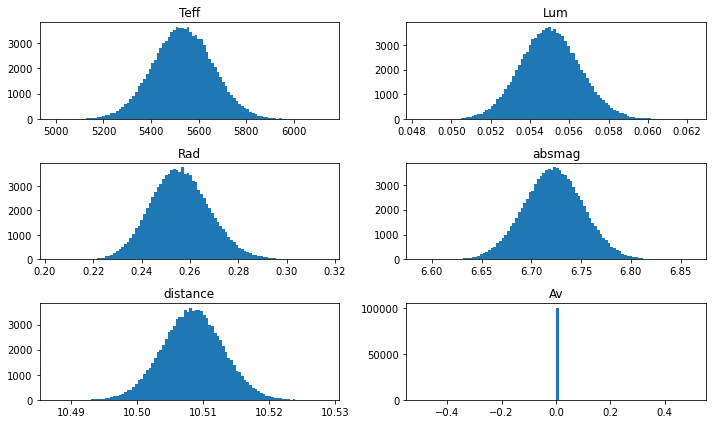

In [35]:
# perform the fit using isoclassify's direct method 
paras = classify_direct.stparas(x, bcmodel=bcmodel, dustmodel=dustmodel, band='jmag', ext=ext, plot=1)

## following the isoclassify readme and GRID tutorial

In [53]:
!pip install dustmaps

Defaulting to user installation because normal site-packages is not writeable
     |████████████████████████████████| 447 kB 4.6 MB/s eta 0:00:01


In [140]:
# for querying 2MASS
!pip install -U pyvo

Defaulting to user installation because normal site-packages is not writeable
Requirement already up-to-date: pyvo in ./.local/lib/python3.7/site-packages (1.1)


In [79]:
# required packages
%matplotlib inline
%reload_ext autoreload
%autoreload 2
import os 
import copy
import glob
import h5py,pdb

import numpy as np
from matplotlib import pylab as plt
import pandas as pd
import astropy.units as units
from astropy.coordinates import SkyCoord
#from dustmaps.config import config
#config.reset()
from dustmaps.bayestar import BayestarWebQuery
import mwdust

from isoclassify.direct import classify as classify_direct
from isoclassify.grid import classify as classify_grid
from isoclassify import DATADIR

DATADIR = '/mnt_home/azuckerman/BL_APF_DAP/isoclassify/isoclassify/data'
DATADIR = './BL_APF_DAP/isoclassify/isoclassify/data'
DATADIR = './isoclassify/isoclassify/data'

In [81]:
# load models
fn = os.path.join(DATADIR,'mesa.h5')
#fn = 'mesa.h5'
file = h5py.File(fn,'r+', driver='core', backing_store=False)
model = {'age':np.array(file['age']),\
'mass':np.array(file['mass']),\
'feh':np.array(file['feh']),\
'teff':np.array(file['teff']),\
'logg':np.array(file['logg']),\
'rad':np.array(file['rad']),\
'lum':np.array(file['rad']),\
'rho':np.array(file['rho']),\
'dage':np.array(file['dage']),\
'dmass':np.array(file['dmass']),\
'dfeh':np.array(file['dfeh']),\
'eep':np.array(file['eep']),\
'bmag':np.array(file['bmag']),\
'vmag':np.array(file['vmag']),\
'btmag':np.array(file['btmag']),\
'vtmag':np.array(file['vtmag']),\
'gmag':np.array(file['gmag']),\
'rmag':np.array(file['rmag']),\
'imag':np.array(file['imag']),\
'zmag':np.array(file['zmag']),\
'jmag':np.array(file['jmag']),\
'hmag':np.array(file['hmag']),\
'kmag':np.array(file['kmag']),\
'd51mag':np.array(file['d51mag']),\
'gamag':np.array(file['gamag']),\
'fdnu':np.array(file['fdnu']),\
'avs':np.zeros(len(np.array(file['gamag']))),\
'dis':np.zeros(len(np.array(file['gamag'])))} #--> why doesn't this work?? It runs if I comment d51mag out.  

#ebf.read(os.path.join(DATADIR,'mesa.ebf'))
# prelims to manipulate some model variables (to be automated soon ...)
#pdb.set_trace()
model['rho'] = np.log10(model['rho'])
model['lum'] = model['rad']**2*(model['teff']/5777.)**4
# next line turns off Dnu scaling relation corrections
model['fdnu'][:]=1.
model['avs']=np.zeros(len(model['teff']))
model['dis']=np.zeros(len(model['teff']))

In [82]:
file.keys()

<KeysViewHDF5 ['age', 'bmag', 'btmag', 'd51mag', 'dage', 'dfeh', 'dmass', 'eep', 'fdnu', 'feh', 'gamag', 'gmag', 'hmag', 'imag', 'jmag', 'kmag', 'logg', 'mass', 'rad', 'rho', 'rmag', 'teff', 'vmag', 'vtmag', 'zmag']>

In [83]:
# define class that contains observables
x = classify_grid.obsdata()

In [84]:
# add [Teff, logg, FeH] and [sigma_Teff, sigma_logg, sigma_FeH] 
#x.addspec([5777.,4.44,0.0],[60.,0.07,0.04])
x.addspec([sm_Teff, sm_logg , sm_feh], [sm_u_Teff, sm_u_logg , sm_u_feh])

In [85]:
# perform classification based on those inputs
paras = classify_grid.classify(input=x, model=model, dustmodel=0,plot=1)

AttributeError: 'obsdata' object has no attribute ''

In [112]:
# NOT RUN BELOW HERE

# print results for radius
paras.rad,paras.radep,paras.radem

# plot the radius posterior
plt.plot(paras.radpx,paras.radpy)

# now let's add some more observables, e.g. a parallax 
x.addplx(parallax,u_parallax)

# and some JHK photometry
x.addjhk([j_mag,h_mag,k_mag],[u_j_mag,u_h_mag,u_k_mag])

# using photometry requires some treatment of reddening and extinction. the following functions
# required for this

def query_dustmodel_coords(ra,dec):
    reddenMap = BayestarWebQuery(version='bayestar2017')
    sightLines = SkyCoord(ra*units.deg,dec*units.deg,frame='icrs')
    reddenContainer = reddenMap(sightLines,mode='best')
    del reddenMap # To clear reddenMap from memory
    distanceSamples = np.array([0.06309573,0.07943284,0.1,0.12589255,0.15848933,0.19952627,0.25118864,0.31622776,0.3981072,0.50118726,0.6309574,0.7943282 ,1.,1.2589258,1.5848933,1.9952621,2.511887,3.1622777,3.981073,5.011873,6.3095727,7.943284,10.,12.589258,15.848933,19.952621,25.11887,31.622776,39.81073,50.11873,63.095726])*1000. # In pc, from bayestar2017 map distance samples
    
    dustModelDF = pd.DataFrame({'ra': [ra], 'dec': [dec]})

    for index in range(len(reddenContainer)):
        dustModelDF['av_'+str(round(distanceSamples[index],6))] = reddenContainer[index]
        
    return dustModelDF
    
def query_dustmodel_coords_allsky(ra,dec):
    reddenMap = mwdust.Combined15()
    sightLines = SkyCoord(ra*units.deg,dec*units.deg,frame='galactic')
    distanceSamples = np.array([0.06309573,0.07943284,0.1,0.12589255,0.15848933,0.19952627,0.25118864,0.31622776,0.3981072,0.50118726,0.6309574,0.7943282 ,1.,1.2589258,1.5848933,1.9952621,2.511887,3.1622777,3.981073,5.011873,6.3095727,7.943284,10.,12.589258,15.848933,19.952621,25.11887,31.622776,39.81073,50.11873,63.095726])*1000. # In pc, from bayestar2017 map distance samples
    reddenContainer=reddenMap(sightLines.l.value,sightLines.b.value,distanceSamples/1000.)
    del reddenMap # To clear reddenMap from memory
    
    dustModelDF = pd.DataFrame({'ra': [ra], 'dec': [dec]})
    
    for index in range(len(reddenContainer)):
        dustModelDF['av_'+str(round(distanceSamples[index],6))] = reddenContainer[index]

    return dustModelDF

def extinction(law):
    if (law == 'cardelli'):
        out = {
            "ab":4.1708789, 
            "av":3.1071930, 
            "abt":4.3358221, 
            "avt":3.2867038, 
            "ag":3.8281101, 
            "ar":2.7386468, 
            "ai":2.1109662, 
            "az":1.4975613, 
            "aj":0.89326176, 
            "ah":0.56273418, 
            "ak":0.35666104, 
            "aga":2.4623915
        }
        
    if (law == 'schlafly11'):
        out = {
            "ab":3.626, 
            "av":2.742, 
            "abt":4.5309214, 
            "avt":3.1026801, 
            "ag":3.303, 
            "ar":2.285, 
            "ai":1.698, 
            "az":1.263, 
            "aj":0.77510388, 
            "ah":0.50818384, 
            "ak":0.33957048, 
            "aga":1.9139634
        }
        
    if (law == 'schlafly16'):
        # see http://argonaut.skymaps.info/usage under "Gray Component". this is a lower limit.
        grayoffset=0.063
        out = {
            "ab":3.6060565+grayoffset, 
            "av":2.9197679+grayoffset, 
            "abt":3.7204173+grayoffset, 
            "avt":3.0353634+grayoffset, 
            "ag":3.384+grayoffset, 
            "ar":2.483+grayoffset, 
            "ai":1.838+grayoffset, 
            "az":1.414+grayoffset, 
            "aj":0.650+grayoffset, 
            "ah":0.327+grayoffset, 
            "ak":0.161+grayoffset, 
            "aga":2.2203186+grayoffset
        }
    return out

# if we don't want to use a reddening map, isoclassify fits for Av. However, we need to 
# define an extinction law
ext = extinction('cardelli')

# perform classification
paras = classify_grid.classify(input=x, model=model, dustmodel=0,plot=1,ext=ext)

# if we want to use a reddening map, we'll need to add coordinates
x.addcoords(ra,dec) # I think this wants ra and dec?

# and define a dustmodel. this is the "allsky" model by Bovy
dustmodel = query_dustmodel_coords_allsky(x.ra,x.dec)

# redo fit, this time using the dustmodel
paras = classify_grid.classify(input=x, model=model, dustmodel=dustmodel,plot=1,ext=ext)



## updated Grid tutorial

In [8]:
# NB: the recommended way to run isoclassify is through the command-line interface (CLI)
# using examples such as given in examples/examples.csv (see README)
# below is an example to run isoclassify from ipython, which requires some hacking by 
# pre-defining functions but allows direct interaction with posteriors.


# required packages
%matplotlib inline
%reload_ext autoreload
%autoreload 2
import os 
import copy
import glob
import h5py,pdb

import numpy as np
from matplotlib import pylab as plt
import pandas as pd
import astropy.units as units
from astropy.coordinates import SkyCoord
#from dustmaps.bayestar import BayestarWebQuery
os.environ['DUST_DIR'] = '/mnt_home/azuckerman/BL_APF_DAP/mwdust/dust_dir'
import mwdust

from isoclassify.direct import classify as classify_direct
from isoclassify.grid import classify as classify_grid
from isoclassify import DATADIR

# to get properties (not done in tutorial)
from astroquery.gaia import Gaia
from astroquery.simbad import Simbad
import pyvo

#DATADIR = '/mnt_home/azuckerman/BL_APF_DAP/isoclassify/isoclassify/data'
#DATADIR = './BL_APF_DAP/isoclassify/isoclassify/data'
#DATADIR = './isoclassify/isoclassify/data'

In [9]:
# get the gaia name
HIP_name = 'HIP10279'
result_table = Simbad.query_objectids(HIP_name)
names = result_table.to_pandas()['ID'].to_list()
gaia_name = [name.decode('utf-8').split(' ')[-1] for name in names if name.decode('utf-8').startswith('Gaia DR2')]
two_MASS_name = [name.decode('utf-8').split('J')[-1] for name in names if name.decode('utf-8').startswith('2MASS')]
(gaia_source_id,) = gaia_name
(id_2MASS,) = two_MASS_name

# get the parallax from gaia
query1 = "SELECT source_id, ra, dec, parallax, parallax_error, teff_val, radius_val  FROM gaiadr2.gaia_source WHERE source_id = " + str(gaia_source_id)
job = Gaia.launch_job(query1)
results = job.get_results()
parallax = float(results['parallax']) #[mas --> milliarsec]
u_parallax = float(results['parallax_error']) #[mas]
ra = float(results['ra']) #[deg]
dec = float(results['dec'])  #[deg]

# get the 2MASS photometry
query2 = "SELECT designation,ra,dec,k_m,h_m,j_m,k_msigcom,h_msigcom,j_msigcom FROM fp_psc WHERE designation = '" + str(id_2MASS) + "'"
service = pyvo.dal.TAPService('https://irsa.ipac.caltech.edu/TAP')
results = service.run_async(query2)

k_mag = float(results['k_m']) # [Mag]
h_mag = float(results['h_m']) # [Mag] 
j_mag = float(results['j_m']) # [Mag]
u_k_mag = float(results['k_msigcom']) # [Mag]
u_h_mag = float(results['h_msigcom']) # [Mag] 
u_j_mag = float(results['j_msigcom']) # [Mag]

In [10]:
# load models
fn = os.path.join(DATADIR,'mesa_from_github.h5')
modfile = h5py.File(fn,'r', driver='core', backing_store=False)
model = {'age':np.array(modfile['age']),\
'mass':np.array(modfile['mass']),\
'feh_init':np.array(modfile['feh']),\
'feh':np.array(modfile['feh_act']),\
'teff':np.array(modfile['teff']),\
'logg':np.array(modfile['logg']),\
'rad':np.array(modfile['rad']),\
'lum':np.array(modfile['rad']),\
'rho':np.array(modfile['rho']),\
'dage':np.array(modfile['dage']),\
'dmass':np.array(modfile['dmass']),\
'dfeh':np.array(modfile['dfeh']),\
'eep':np.array(modfile['eep']),\
'bmag':np.array(modfile['bmag']),\
'vmag':np.array(modfile['vmag']),\
'btmag':np.array(modfile['btmag']),\
'vtmag':np.array(modfile['vtmag']),\
'gmag':np.array(modfile['gmag']),\
'rmag':np.array(modfile['rmag']),\
'imag':np.array(modfile['imag']),\
'zmag':np.array(modfile['zmag']),\
'jmag':np.array(modfile['jmag']),\
'hmag':np.array(modfile['hmag']),\
'kmag':np.array(modfile['kmag']),\
'bpmag':np.array(modfile['bpmag']),\
'gamag':np.array(modfile['gamag']),\
'rpmag':np.array(modfile['rpmag']),\
'fdnu':np.array(modfile['fdnu']),\
'avs':np.zeros(len(np.array(modfile['gamag']))),\
'dis':np.zeros(len(np.array(modfile['gamag'])))}

#ebf.read(os.path.join(DATADIR,'mesa.ebf'))
# prelims to manipulate some model variables (to be automated soon ...)
#pdb.set_trace()
model['rho'] = np.log10(model['rho'])
model['lum'] = model['rad']**2*(model['teff']/5777.)**4
# next line turns off Dnu scaling relation corrections
model['fdnu'][:]=1.
model['avs']=np.zeros(len(model['teff']))
model['dis']=np.zeros(len(model['teff']))

In [4]:
DATADIR

'/home/azuckerman/.isoclassify'

In [11]:
# define class that contains observables
x = classify_grid.obsdata()

In [12]:
# add [Teff, logg, FeH] and [sigma_Teff, sigma_logg, sigma_FeH] 
# currently just copied from a results file -- will read these in from SM
sm_R = 	0.429 # 1.659
sm_Teff = 3588 # 5533.
sm_feh = -0.453 # 0.057
sm_logg = 4.811 # 4.0
sm_u_R = 0.1 # 0.340
sm_u_Teff = 70 # 125.8
sm_u_feh = 0.09 # 0.09
sm_u_logg = 0.12 # 0.09
x.addspec([sm_Teff, sm_logg , sm_feh], [sm_u_Teff, sm_u_logg , sm_u_feh])
#x.addspec([5777.,4.44,0.0],[60.,0.07,0.04])

teff 2000098
feh 82086
number of models used within non-phot obsconstraints: 82086
number of models after phot constraints: 82086
----
teff 3665.4632269922377 63.242512769103996 72.51226256575183
logg 4.973636047572743 0.06269771711744898 0.06438809993764227
feh -0.4178228470622584 0.09623328664177755 0.06854711789177936
rad 0.2528940956970139 0.05451701162229461 0.042613255165678654
mass 0.22600478183357042 0.06202684142200032 0.04508125176812666
rho 13.078568297568395 5.012413040458711 3.764270704459877
lum 0.010446210236765069 0.005738309294076113 0.003669566249814981
age 10.090407146483411 6.523372176344683 6.627637052156659


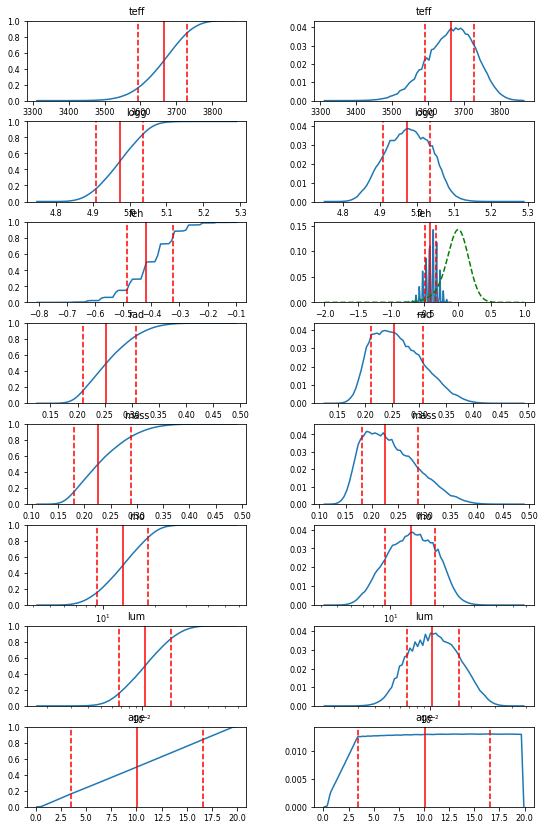

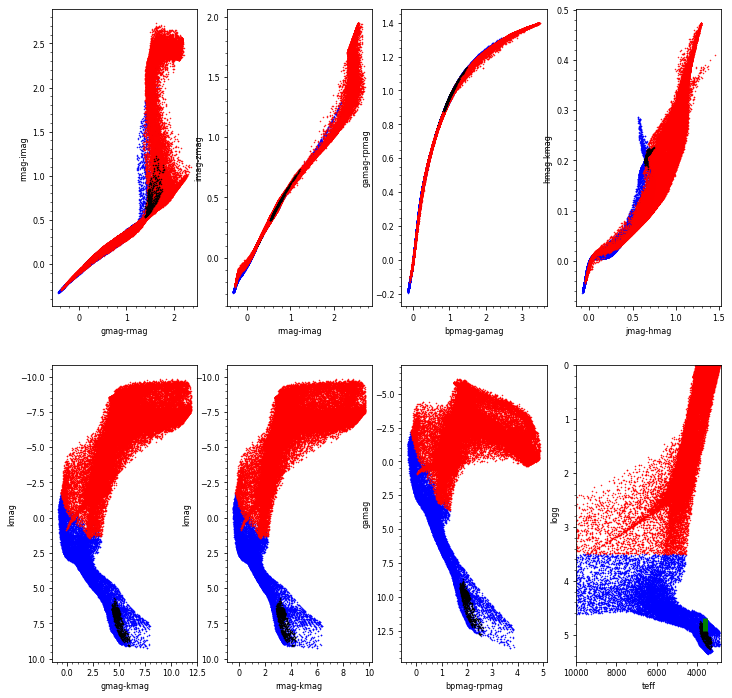

In [13]:
# perform classification based on those inputs
paras = classify_grid.classify(input=x, model=model, dustmodel=0,plot=1,band='kmag')

In [7]:
# print results for radius
paras.rad,paras.radep,paras.radem

(0.2528940956970139, 0.05451701162229461, 0.042613255165678654)

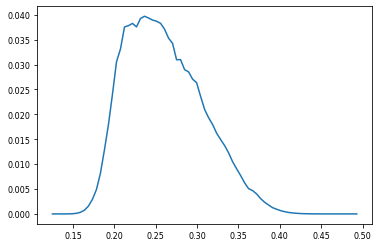

In [8]:
# plot the radius posterior
plt.plot(paras.radpx,paras.radpy)

In [9]:
# now let's add some more observables, e.g. a parallax 
# PARALLAX
x.addplx(parallax/1000,u_parallax/1000) # /1000 to convert to arsec

In [10]:
# and some JHK photometry

# 2MASS PHOTOMETRY
x.addjhk([j_mag,h_mag,k_mag],[u_j_mag,u_h_mag,u_k_mag])

In [11]:
# using photometry requires some treatment of reddening and extinction. the following functions
# required for this

def query_dustmodel_coords(ra,dec,dust):
    if dust == 'allsky':
        reddenMap = mwdust.Combined19()
        ext = extinction('green19')
    if dust == 'green19':
        reddenMap = mwdust.Green19()
        ext = extinction('green19')
    if dust == 'zero':
        reddenMap = mwdust.Zero()
        ext = extinction('cardelli')
    if dust == 'none':
        reddenMap = 0
        ext = extinction('cardelli')
        print('Fitting for reddening.')
        return reddenMap,ext

    sightLines = SkyCoord(ra*units.deg,dec*units.deg,frame='icrs')
    sightLines = sightLines.transform_to('galactic')

    PACKAGEDIR='../isoclassify/'

    distanceSamples = np.loadtxt(f"{PACKAGEDIR}/data/distance-samples-green19.txt",delimiter=',')*1000.

    reddenContainer = reddenMap(sightLines.l.value,sightLines.b.value,distanceSamples/1000.)

    del reddenMap # To clear reddenMap from memory

    dustModelDF = pd.DataFrame({'ra': [ra], 'dec': [dec]})

    for index in range(len(reddenContainer)):
        dustModelDF['av_'+str(round(distanceSamples[index],6))] = reddenContainer[index]

    return dustModelDF,ext


# using photometry requires some treatment of reddening and extinction. the following functions
# required for this

def query_dustmodel_coords(ra,dec,dust):
    if dust == 'allsky':
        reddenMap = mwdust.Combined19()
        ext = extinction('green19')
    if dust == 'green19':
        reddenMap = mwdust.Green19()
        ext = extinction('green19')
    if dust == 'zero':
        reddenMap = mwdust.Zero()
        ext = extinction('cardelli')
    if dust == 'none':
        reddenMap = 0
        ext = extinction('cardelli')
        print('Fitting for reddening.')
        return reddenMap,ext

    sightLines = SkyCoord(ra*units.deg,dec*units.deg,frame='icrs')
    sightLines = sightLines.transform_to('galactic')

    PACKAGEDIR='../isoclassify/'

    distanceSamples = np.loadtxt(f"{PACKAGEDIR}/data/distance-samples-green19.txt",delimiter=',')*1000.

    reddenContainer = reddenMap(sightLines.l.value,sightLines.b.value,distanceSamples/1000.)

    del reddenMap # To clear reddenMap from memory

    dustModelDF = pd.DataFrame({'ra': [ra], 'dec': [dec]})

    for index in range(len(reddenContainer)):
        dustModelDF['av_'+str(round(distanceSamples[index],6))] = reddenContainer[index]

    return dustModelDF,ext

def extinction(law):

    PACKAGEDIR='./BL_APF_DAP/isoclassify/isoclassify' # ADZ modification 
    if (law == 'cardelli'):
        out = {}

        with open(f"{PACKAGEDIR}/data/extinction-vector-cardelli-iso.txt") as f:

            for line in f:
                (key,val) = line.split(',')
                out[key] = float(val)

    if (law == 'schlafly11'):
        out = {}

        with open(f"{PACKAGEDIR}/data/extinction-vector-schlafly11-iso.txt") as f:

            for line in f:
                (key,val) = line.split(',')
                out[key] = float(val)

    if (law == 'schlafly16'):
        # see http://argonaut.skymaps.info/usage under "Gray Component". this is a lower limit.
        grayoffset=0.063
        out = {}

        with open(f"{PACKAGEDIR}/data/extinction-vector-schlafly16-iso.txt") as f:

            for line in f:
                (key,val) = line.split(',')
                out[key] = float(val)+grayoffset

    if (law == 'green19'):
        out = {}

        with open(f"{PACKAGEDIR}/data/extinction-vector-green19-iso.txt") as f:
            
            for line in f:
                (key,val) = line.split(',')
                out[key] = float(val)
    return out


In [12]:
# if we don't want to use a reddening map, isoclassify fits for Av. However, we need to 
# define an extinction law
ext = extinction('cardelli')

M-dwarf with K band magnitude detected!
M_K from photometry:  0.03590237075158457
M_K error from best-fit polynomial:  0.056575833842786645
After adding in quadrature, using M_K error:  0.06700600869019761
teff 2000098
feh 82086
number of models used within non-phot obsconstraints: 82086
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
number of models incl reddening: 10671180
number of models after phot constraints: 302741
----
teff 3845.1260827190513 14.809492753341146 26.469452243837168
logg 4.807792037729181 0.011708707228748949 0.009533616229175479
feh -0.336646046610653 0.08297080703351883 0.08375049733000106
rad 0.4221602823

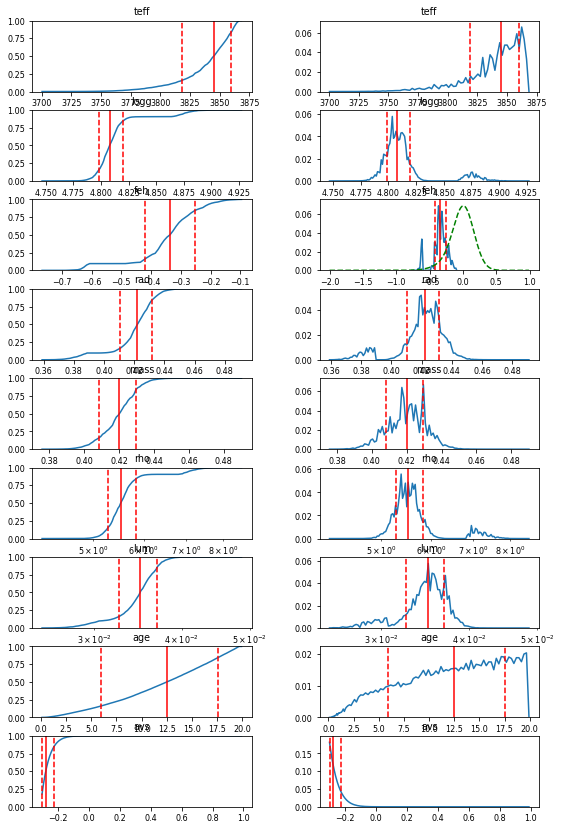

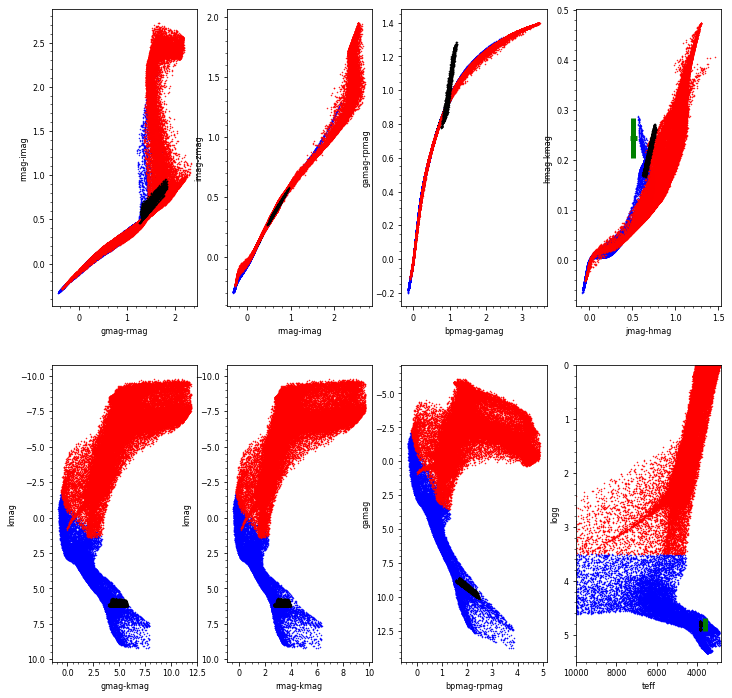

In [13]:
# perform classification
paras = classify_grid.classify(input=x, model=model, dustmodel=0,plot=1,ext=ext,band='kmag')

## Other code

In [ ]:
    # copied from iso_cps_cerion4keck.py -- NOT TESTED     
    # Query Simbad for parallax and kmag.
        obs_name = self.outdir.split('/')[-1]
        name = obs_name.split('_')[0]

        # Fix names. Imperfect but covers relevant cases.
        if name[0] == 'T':
            pass
        elif 'GL' in name or 'GJ' in name or 'gl' in name or 'gj' in name:
            name = name[:2] + ' ' + name[2:].upper()
        elif 'HIP' in name or 'hip' in name:
            name = name[:3] + ' ' + name[3:].upper()
        elif name[0].isdigit() and '-' not in name:
            name = 'HD ' + name.upper()
        else:
            name = name.upper()

        try:
            sq = sbad.query_object('{}'.format(name))
        except requests.exceptions.ConnectionError:
            print("Query timeout on target {}".format(input_names.iloc[0]))
            time.sleep(5)
            sq = sbad.query_object('{}'.format(name))

        ex = {'kmag': '', 'kmag_err': '',
              'parallax': '', 'parallax_err': ''}

        # Some CPS stars have unnecessary a or b at end of name.
        if sq is None and (name[-1] == 'A' or name[-1] == 'B'):
            try:
                sq = sbad.query_object('{}'.format(name[:-1]))
            except requests.exceptions.ConnectionError:
                print("Query timeout on target {}".format(input_names.iloc[0]))
                time.sleep(5)
                sq = sbad.query_object('{}'.format(name[:-1]))

        # Binaries don't query correctly so try A component if not specified
        if sq is None:# or np.isnan(sq['FLUX_K'].data[0]):
            try:
                sq = sbad.query_object('{} A'.format(name))
            except requests.exceptions.ConnectionError:
                print("Query timeout on target {}".format(input_names.iloc[0]))
                time.sleep(5)
                sq = sbad.query_object('{} A'.format(name))

        try:
            ex['parallax'] = sq['PLX_VALUE'].data[0] / 1000.
            ex['parallax_err'] = sq['PLX_ERROR'].data[0] / 1000.
        except TypeError:
            pass
        try:
            ex['kmag'] = sq['FLUX_K'].data[0]
            ex['kmag_err'] = 0.03  # assume 3% error floor on K measurements
        except TypeError:
            pass

        # Hack to deal with inexplicable simbad query fails
        if name == "HD 17156":
            ex['kmag'] = 6.763
        if name == "HD 80606":
            ex['kmag'] = 7.316
            ex['parallax'] = 0.0153
            ex['parallax_err'] = 0.0000031
        if name == "KELT-4A":
            ex['kmag'] = 8.689
        if name == "KELT-2A":
            ex['kmag'] = 7.346
        if name == "HD 149026":
            ex['kmag'] = 6.819
        if name == "HD 95735":
            ex['kmag'] = 3.34
            ex['kmag_err'] = 0.05
            ex['parallax'] = 392.752945 / 1000.
            ex['parallax_err'] = 0.03206665 / 1000.


        # If Simbad query successful, pull in parallax & kmag.
        if not isinstance(ex['kmag'], str) and not isinstance(ex['parallax'], str):
            x.addjhk([-99, -99, ex['kmag'] ],[0, 0, ex['kmag_err']])
            x.addplx(ex['parallax'], ex['parallax_err'])


hi


NameError: name 'sm' is not defined

## testing using iso.py

In [63]:
import os
#os.chdir('./BL_APF_DAP') # if it suddenly won't import things becuase working direcoty is wrong
import astropy.io.fits 
import numpy as np
import matplotlib.pyplot as plt
import sys, path
import os
import import_ipynb 
sys.path.append('specmatch-emp')
import specmatchemp.library
import specmatchemp.plots as smplot
from specmatchemp.spectrum import Spectrum
from specmatchemp.specmatch import SpecMatch
from rescale import get_rescaled_wave_soln
from rescale import resample
import astropy.io.fits as pf
from bstar_deblaze import bstar_deblazed2
from astropy.io import fits
from specmatch_cps_master.smcps.smemp.iso import Isochrone

KeyError: 'SMCPS_MAX_PROC'

In [56]:
# just get the spectrum object in this cell

path = '/mnt_home/azuckerman/BL_APF_DAP/APF_spectra/all_apf_spectra_highest_SNR/HIP98906_spectra/rask.201.fits' # for example
hdul = astropy.io.fits.open(path)

# take median of all orders
header = hdul[0].header
data = hdul[0].data

data = data/np.percentile(np.sort(data),99)

orders  = np.linspace(30,51,22).astype(int)
norm_deblazed = np.zeros([len(orders), 4600])
for order in orders:
    data[order,:4600]  = bstar_deblazed2(data, order)
    norm_deblazed[order-30] = data[order,:4600]


# Use Specmatch-Emp to get registered wavelength scale
# Get a wavelength solution rescaled onto the scale of the library
wave_soln_ref = get_rescaled_wave_soln()

# Resample the spectrum onto the new wavelength scale
wave_soln = (pf.open('apf_wav.fits'))[0].data# hdul[0].data
data_new = resample(wave_soln_ref, wave_soln, data)

# Create spectrum object
my_spectrum = Spectrum(np.asarray(wave_soln_ref), np.asarray(data_new))

lib = specmatchemp.library.read_hdf()

sm = SpecMatch(my_spectrum, lib)

# Perform shift
sm.shift()

sm.match()

    # Perform lincomb
    # NOTE: detrend() is called within lincomb(),
    #       so after this sm.results() gives detrended and sm.results_nodetrend() gives non-detrended results.
sm.lincomb()

importing Jupyter notebook from rescale.ipynb
importing Jupyter notebook from bstar_deblaze.ipynb


bstar_deblaze.ipynb:185: RuntimeWarning: invalid value encountered in true_divide
  "    y_norm = y/np.percentile(np.sort(y),99)\n",


Finished deblaze
Finished deblaze
Finished deblaze
Finished deblaze
Finished deblaze
Finished deblaze
Finished deblaze
Finished deblaze
Finished deblaze
Finished deblaze
Finished deblaze
Finished deblaze
Finished deblaze
Finished deblaze
Finished deblaze
Finished deblaze
Finished deblaze
Finished deblaze
Finished deblaze
Finished deblaze
Finished deblaze
Finished deblaze
Finished rescale
Finished resample
Reading library from /home/azuckerman/.specmatchemp/library.h5
Shifting spectrum
Shifting spectrum Spectrum 1
Attempting shift to spectrum NSO, median cross-correlation peak = 0.58
Attempting shift to spectrum 123239, median cross-correlation peak = 0.64
Attempting shift to spectrum 222368, median cross-correlation peak = 0.43
Attempting shift to spectrum 216899, median cross-correlation peak = 0.87
Best reference for shifting: 216899
Shifting entire spectrum
Matching spectrum
Matching region (5000, 5100)
Matching region (5100, 5200)
Matching region (5200, 5300)
Matching region (5300,

In [57]:
iso = Isochrone()
iso.run_isochrones()


NameError: name 'Isochrone' is not defined

In [66]:
!pip install cpsutils

Defaulting to user installation because normal site-packages is not writeable
ERROR: Could not find a version that satisfies the requirement cpsutils (from versions: none)
ERROR: No matching distribution found for cpsutils


In [65]:
os.environ

environ{'USER': 'azuckerman',
        'JUPYTERHUB_HOST': '',
        'JUPYTERHUB_USER': 'azuckerman',
        'HOME': '/home/azuckerman',
        'JUPYTERHUB_OAUTH_CALLBACK_URL': '/user/azuckerman/oauth_callback',
        'JUPYTERHUB_API_URL': 'http://127.0.0.1:8081/hub/api',
        'HDF5_USE_FILE_LOCKING': 'FALSE',
        'JUPYTERHUB_CLIENT_ID': 'jupyterhub-user-azuckerman',
        'PATH': '/opt/conda/bin:/opt/conda/condabin:/usr/local/sbin:/usr/local/bin:/usr/sbin:/usr/bin:/sbin:/bin:/snap/bin',
        'JUPYTERHUB_ACTIVITY_URL': 'http://127.0.0.1:8081/hub/api/users/azuckerman/activity',
        'LANG': 'en_US.UTF-8',
        'SHELL': '/bin/bash',
        'CONDA_DEFAULT_ENV': 'base',
        'JUPYTERHUB_SERVICE_PREFIX': '/user/azuckerman/',
        'JUPYTERHUB_API_TOKEN': '44b2b4fa6f61453bbcf6a7e2587f8cd0',
        'PWD': '/mnt_home/azuckerman',
        'JUPYTERHUB_SERVER_NAME': '',
        'JUPYTERHUB_BASE_URL': '/',
        'JPY_API_TOKEN': '44b2b4fa6f61453bbcf6a7e2587f8cd0',
  

In [ ]:
os.getcwd()

In [13]:
paras.age = np.nan

In [15]:
paras.mass

0.22600478183357042

In [4]:
test_res = classify_grid.resdata()

In [7]:
test_res.rad

0.0

In [20]:
'{0:.3f}'.format(paras.age)

'10.090'